In [ ]:
%load core.py

---------------------------
PATHS
---------------------------
base: /home/lachlan/CODEBASE/RadialCTF
data: /home/lachlan/CODEBASE/RadialCTF/data
output: /home/lachlan/CODEBASE/RadialCTF/out
---------------------------
2 300
opening .tifs beginning with: /home/lachlan/CODEBASE/RadialCTF/data/0.05 s.tif
no frames: 300
Read frame :  0 True
Read frame :  1 True
Read frame :  2 True
Read frame :  3 True
Read frame :  4 True
Read frame :  5 True
Read frame :  6 True
Read frame :  7 True
Read frame :  8 True
Read frame :  9 True
Read frame :  10 True
Read frame :  11 True
Read frame :  12 True
Read frame :  13 True
Read frame :  14 True
Read frame :  15 True
Read frame :  16 True
Read frame :  17 True
Read frame :  18 True
Read frame :  19 True
Read frame :  20 True
Read frame :  21 True
Read frame :  22 True
Read frame :  23 True
Read frame :  24 True
Read frame :  25 True
Read frame :  26 True
Read frame :  27 True
Read frame :  28 True
Read frame :  29 True
Read frame :  30 True
Read frame

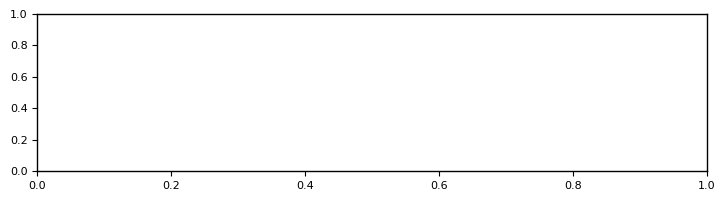

In [1]:
# %load core.py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import cv2
import os
from scipy.optimize import curve_fit

import src.utils as utils

""""
Simple tool to fit radial contrast transfer function to TEM images to detect radial drift in first zero

- Receives either .avi movie files or stacks of .tif files
- Calculates FFT if in real space
- Generates radial profiles around image centre at given phi, sector width
- Fits CTF to each sector profile
- calculates basic properties across stack

variables in config.py control filetype and other params

Example data in ./data

FFT from:
https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/

avi read from:
#https://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
"""

#-----------------------------------
#INITIALISE
#-----------------------------------

f, fname, script, spath, wdir, odir, vidcap, flist, nframes, ftype = utils.initialise()

#-----------------------------------
#MAIN START
#-----------------------------------

#initalise result arrays
times= np.empty(nframes, dtype="U10")    #timestamps
zavg=np.zeros(nframes)                   #zero point average
zsd=np.zeros(nframes)                    #zero point std dev
secsd=np.zeros(nframes)                  #std dev between sectors
r2avg=np.zeros(nframes)                  #average r2 value for fit

#initialise tracking vars
framecount = 0
success = True

#--------------------
#READ frame by frame
#   while prev frame successfully read
#--------------------
while success:

    figx, figy, secstep, colourmap, fourierspace, debug, centrecut, secwidth, \
        pxpitch, pxdim = utils.getimgparams()

    #initialise plot and colourmaps per frame
    plt.rcParams["figure.figsize"] = [figx/2.54, figy/2.54]
    plt.rcParams["figure.figsize"] = [figx/2.54, figy/2.54]
    fig=plt.figure()
    steps=np.arange(0, 180, secstep)    #no. steps for radial masks
    lut = cm = plt.get_cmap(colourmap) 
    cNorm  = colors.Normalize(vmin=0, vmax=len(steps)+2)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=lut)

    #initialise frame plot
    axgph=fig.add_axes([0.08,0.1,0.85,0.4])

    #READ NEXT FRAME
    #filetype switcher again - read .avi and .tif differently
    #   paired with switcher at top of main 
    #   - be very careful that all branches send the same results downstream
    if ftype == ".avi":
        #read a frame from the avi, returning success
        success,readimage = vidcap.read()
    elif ftype == ".tif":    
        #read image, provided current frame is less than total frames
        if framecount < len(flist):
            #assign working .tif file
            f=flist[framecount]

            #read in the image
            readimage = cv2.imread(f, 0)

            #return success state based on whether readimage has data
            if readimage.size >= 0:
                success=True
            else:
                print("failed for",f)
                success=False
        #if current frame higher than filelist, report failure
        else:
            success=False
    else:
        raise TypeError(f'Filetype {ftype} not recognised')

    print('Read frame : ', framecount, success)

    #leave loop if import unsuccessful (ie. no more frames)
    if not success:
        break

    # Check if image is rgb (shape=3 means 3-channels)
    #   and convert to grayscale if needed
    # error if more than 3 channels (eg. alpha channel)
    # continue as-is if two channels

    if len(readimage.shape) == 3:
        #readimage = readimage[:, :, :3].mean(axis=2) 	#old conversion, not sure on difference
        readimage = cv2.cvtColor(readimage, cv2.COLOR_BGR2GRAY)

    elif len(readimage.shape) > 3 :
        print("FATAL: unrecognised format, too many channels in frame:", len(readimage.shape))
         
    #if input is not in fourierspace
    #   do an FFT
    #   otherwise assign ftimage as readimage
    if fourierspace == False:
        # Array dimensions (array is square) and centre pixel
        # Use smallest dimension and ensure value is odd
        array_size = min(readimage.shape) - 1 + min(readimage.shape) % 2

        # Crop image to square
        readimage = readimage[:array_size, :array_size]
        centre = int((array_size - 1) / 2)

        # Get all coordinate pairs in the left half of the array,
        # including the column at the centre of the array (which
        # includes the centre pixel)
        coords_left_half = (
            (x, y) for x in range(array_size) for y in range(centre+1)
        )

        # Sort points based on distance from centre
        coords_left_half = sorted(
            coords_left_half,
            key=lambda x: utils.calculate_distance_from_centre(x, centre)
        )

        # fourier transform this frame
        ftimage = (abs(utils.calculate_2dft(readimage)))
    else:   #if we don't need an FT
        #assign input as output FT
        ftimage=readimage
    
    #if debugmode is on, show first frame realspace vs FFT then exit
    if debug == True:
    # Show grayscale image and its Fourier transform
        plt.set_cmap("gray")
        plt.subplot(121)
        plt.imshow(readimage)
        plt.axis("off")
        plt.subplot(122)
    #    print(ftimage)
    #    print(np.abs(ftimage))
    #    cv2.imwrite(os.path.join(odir, "fft_%s.tif" % fname),np.abs(ft))
        plt.imshow(np.log(abs(ftimage)))
        plt.axis("off")
        plt.pause(2)
    
        plt.show()
        exit()
    
# get image centres, outer radius
    centrex, centrey = tuple(np.array(ftimage.shape[1::-1]) / 2)
    centrex=int(centrex)
    centrey=int(centrey)
    radcut=int(max(centrex, centrey)*0.9)
    rpoints=radcut-centrecut-1
    
    #initialise the profile array
    profiles=np.zeros((len(steps),rpoints,2))
    ctfs=np.zeros((len(steps),rpoints))
    zvals=np.zeros(len(steps))
    r2=np.zeros(len(steps))

    stepcount=0 #stepcounter
#   create series of radial masks
#       iterate through each mask position according to secwith and secstep
    for secpos in steps:

        #duplicate the image
        img = np.copy(ftimage)
        colorVal = scalarMap.to_rgba(stepcount)
        #initialise mask from sector coords
        th1=secpos-secwidth/2
        th2=secpos+secwidth/2
        #generate the paired masks
        mask = utils.sector_mask(img.shape,(centrex,centrey),radcut,(th1,th2))
        mask += utils.sector_mask(img.shape,(centrex,centrey),radcut,(th1+180,th2+180))
        #add masks on centre xy column/rows
        mask[:,centrey] = False
        mask[centrex,:] = False
        #apply mask               
        img[~mask] = 0

    #   get the centre and centremask
        center, ccut = (centrex, centrey), centrecut
        
    #   create the azimuthal profile (x,rad) and add to master matrix for this image
        rad = utils.radial_profile(img, center)
        x = np.arange(rad.shape[0])
        rad=rad[ccut:(radcut)]
        x=x[ccut:(radcut)]
        rad=rad[:rpoints]
        x=x[:rpoints]
        profiles[stepcount,:,:] = np.c_[x, rad]

    #   https://stackoverflow.com/questions/22895794/scipys-optimize-curve-fit-limits
    #   FITTING HERE
    #--------------------------------------------------------
        # k=x
        k=x/(pxpitch*pxdim)  
        
        amp, cs, wl, dz, dm, dec, const, gsig, gamp, bf0, bf1, bf2, bf3, etime = utils.getfitparams()

        guess=np.array([amp, cs, wl, dz, dm, dec, const, gsig, gamp])

        bounded=([amp/bf3, cs/(bf0), wl/bf0, dz/bf2, dm/bf2, dec/bf3, const/bf3, gsig/bf2, gamp/bf2], [amp*bf2, cs*bf0, wl*bf0, dz*bf2, dm*bf2, dec*bf2, const*bf1, gsig*bf2, gamp*bf2])

    #   DO FIT 
        popt, pcov = curve_fit(utils.ctfmodel, k, rad, p0=guess, bounds=bounded)
    #--------------------------------------------------------

        #populate final models
        ctf=utils.ctfmodel(k, *popt)
        ctfs[stepcount,:]=ctf

        #create model for sin component
        sinfac=np.sin( (np.pi/2)*(popt[1]*popt[2]**3*k**4 - 2*popt[3]*popt[2]*k**2))

        #get index of first crossing of x-axis -> zero point
        zpoint=utils.zerocross(sinfac)[0]
        zvals[stepcount]=k[zpoint]

    #   calc r2 value as rough goodness-of-fit

        # residual sum of squares
        ss_res = np.sum((rad - ctf) ** 2)

        # total sum of squares
        ss_tot = np.sum((rad - np.mean(rad)) ** 2)

        # r-squared
        r2[stepcount] = 1 - (ss_res / ss_tot)

        #   PLOTS
        #plot data, fits, zeropoint

        axrad=fig.add_axes([0.08+0.217*stepcount,0.52,0.20,0.45])
        axrad.spines[:].set_linewidth(2)
        axrad.spines[:].set_color(colorVal)
        axrad.set_xticklabels([])
        axrad.set_yticklabels([])
        axrad.tick_params(color=colorVal, labelcolor=colorVal)
        axrad.imshow(img)
        axgph.plot(k, rad,
            label="%d deg" % secpos,
            color=colorVal)
        axgph.plot(k, ctf, 
            ':',
            color=colorVal)

        axgph.axvline(x=k[zpoint], color=colorVal, linestyle='--')    
        axgph.text(k[zpoint]*1.05,0.95*max(ctf),
            ("%.3f $nm^{-1}$" % k[zpoint]),
            horizontalalignment='left',
            color=colorVal)
        stepcount += 1   #increment stepcounter

    #FINAL PLOT per tiff

    #adjust labels, legends etc    
    axgph.set_ylabel('Intensity')
    axgph.set_xlabel('Spatial frequency (1/nm)')
    axgph.legend(loc="upper right")
   
    #add stats to output matrices
    times[framecount]=etime*framecount
    zavg[framecount]=np.average(zvals)
    zsd[framecount]=np.std(zvals)
    r2avg[framecount]=np.average(r2)

#   would be useful to report difference between sector ctfs as well


 #output the final figure for this frame
    fig.savefig(os.path.join(odir, ("out_%s.png" % framecount)), dpi=300)

#   clear and close the figure
#       note: this is slow, costs about 20% performance
#       ideally would clear individual axes instead eg. axgh.cla() axrad.cla()
#       doesnt seem to clear fully, do this for now
    fig.clf()
    plt.close()

    framecount += 1

#print the final list of report values and save to  file
#   need to improve formatting here, np array has to be single dtype so all string currently
np.savetxt(os.path.join(odir, "results.txt"), np.c_[times, r2avg, zavg, zsd], newline='\n', fmt=['%12s','%12s','%12s','%12s'], header="      time       r2               zero avg          zero var")

print("CLEAN END")